In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
import pickle as pkl
import os

from utils.point_generation import generate_points, generate_points_random
from utils.homography import get_homography, apply_homography
from utils.plotting import points_to_image, plot_points_as_image, plot_multiple_images

In [6]:
# set up original camera matrix
f = 300
K = np.diag([300, 300, 1])
K[0, 2] = f // 2
K[1, 2] = f // 2

C = np.array([0, 0, 0, 1])

P = K @ (np.hstack([np.eye(3), -(C[:3] / C[3]).reshape(-1, 1)]))
P

array([[300.,   0., 150.,   0.],
       [  0., 300., 150.,   0.],
       [  0.,   0.,   1.,   0.]])

In [ ]:
def get_rotated_camera(K, C, x=0, y=0, z=0):
    """Apply a rotation to a camera matrix"""
    R = np.eye(3)
    R = R @ cv2.Rodrigues(np.array([x, y, z]))[0]
    P = K @ np.hstack([R, -(C[:3] / C[3]).reshape(-1, 1)])
    return P



In [9]:
P_30z = get_rotated_camera(K, C, z=np.pi/6)
P_15x = get_rotated_camera(K, C, x=np.pi/12)

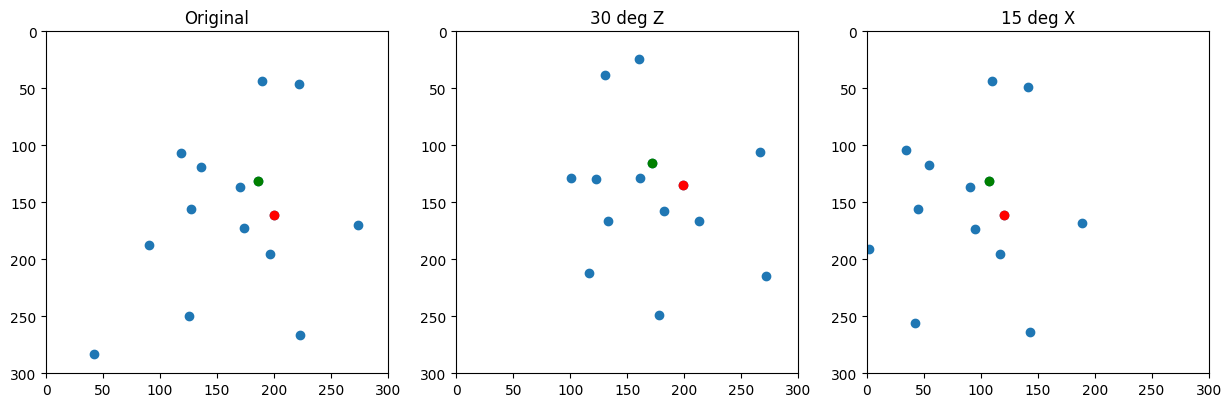

In [10]:
# may be wrong
# x left-right, y top-bottom, z near-far

# orig starts bottom-up, left-right
# rotation via image correctly goes 30 deg clockwise, based on z axis
# with matplotlib, first column is x (left-right), second is y (bottom-up)

# when working with creating the image, we need to flip the y axis, and make sure that the axis order is correct (ij does top-down, left-right)
# points_3dh = generate_points(5, 10)
points_3dh = generate_points_random(15)
points_2dh_orig = points_3dh @ P.T
points_2d_orig = points_2dh_orig[:, :2] / points_2dh_orig[:, 2].reshape(-1, 1)

points_2dh_30z = points_3dh @ P_30z.T
points_2d_30z = points_2dh_30z[:, :2] / points_2dh_30z[:, 2].reshape(-1, 1)

points_2dh_15x = points_3dh @ P_15x.T
points_2d_15x = points_2dh_15x[:, :2] / points_2dh_15x[:, 2].reshape(-1, 1)

plot_points_as_image(points_2d_orig, points_2d_30z, points_2d_15x, titles=['Original', '30 deg Z', '15 deg X'])

In [11]:
if not os.path.exists('data'):
    os.makedirs('data')

if not os.path.exists('data/image_orig_random.pkl'):
    image_orig = points_to_image(points_2d_orig)
    with open('data/image_orig_random.pkl', 'wb') as f:
        pkl.dump(image_orig, f)
else:
    with open('data/image_orig_random.pkl', 'rb') as f:
        image_orig = pkl.load(f)

if not os.path.exists('data/image_30z_random.pkl'):
    image_30z = points_to_image(points_2d_30z)
    with open('data/image_30z_random.pkl', 'wb') as f:
        pkl.dump(image_30z, f)
else:
    with open('data/image_30z_random.pkl', 'rb') as f:
        image_30z = pkl.load(f)

if not os.path.exists('data/image_15x_random.pkl'):
    image_15x = points_to_image(points_2d_15x)
    with open('data/image_15x_random.pkl', 'wb') as f:
        pkl.dump(image_15x, f)
else:
    with open('data/image_15x_random.pkl', 'rb') as f:
        image_15x = pkl.load(f)

H_30z = get_homography(points_2d_30z, points_2d_orig, normalize=True)
H_15x = get_homography(points_2d_15x, points_2d_orig, normalize=True)
rectified_image_30z = apply_homography(image_30z, H_30z, (0, 0, 300, 300))
rectified_image_15x = apply_homography(image_15x, H_15x, (0, 0, 300, 300))

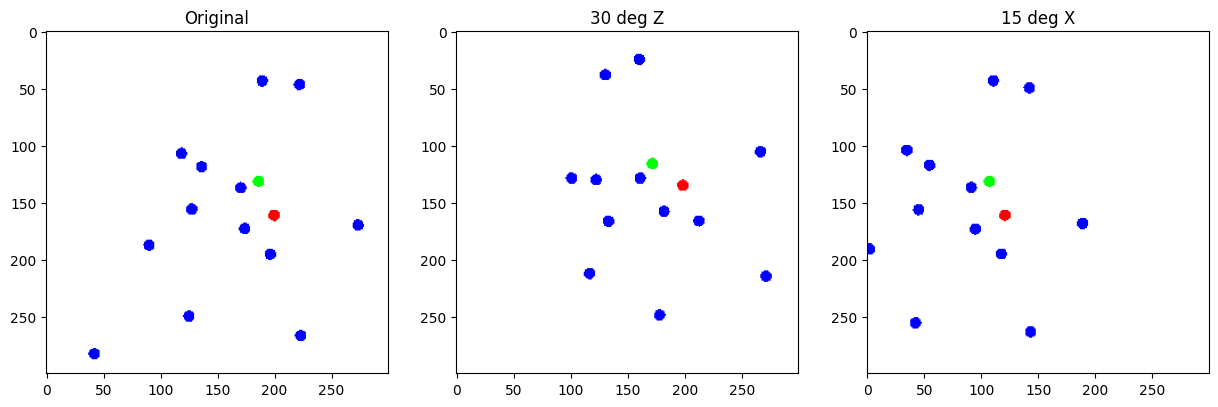

In [21]:
plot_multiple_images(image_orig, image_30z, image_15x, titles=['Original', '30 deg Z', '15 deg X'])

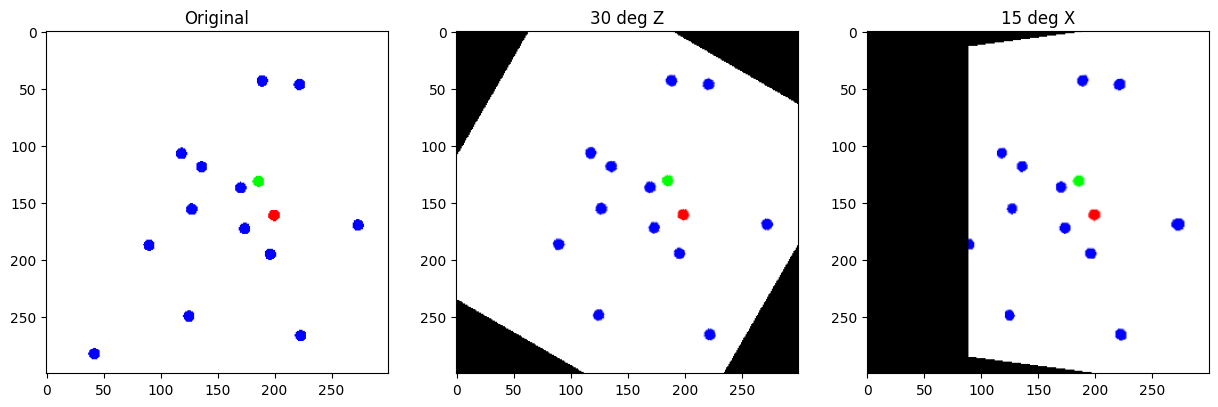

In [12]:
plot_multiple_images(image_orig, rectified_image_30z, rectified_image_15x, titles=['Original', '30 deg Z', '15 deg X'])

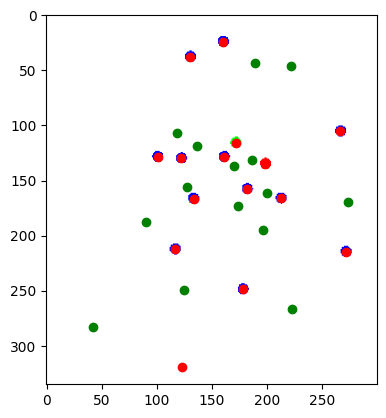

In [22]:
plt.imshow(image_30z)
plt.scatter(points_2d_30z[:, 1], points_2d_30z[:, 0], c='r')

rectified_points = np.hstack([points_2d_30z, np.ones((points_2d_30z.shape[0], 1))]) @ H_30z.T
rectified_points = rectified_points[:, :2] / rectified_points[:, 2].reshape(-1, 1)
plt.scatter(rectified_points[:, 1], rectified_points[:, 0], c='g')

In [23]:
H1 = get_homography(points_2d_orig, points_2d_30z, normalize=True)
H2 = get_homography(points_2d_orig, points_2d_15x, normalize=True)
H1_inv = np.linalg.inv(H1)
H2_inv = np.linalg.inv(H2)

H_invs = [H1_inv, H2_inv]

A = np.zeros((0, 6))

for i in range(2):
    h1, h2, h3, h4, h5, h6, h7, h8, h9 = H_invs[i].ravel()

    row1 = np.array([h1**2 - 1, 2*h1*h4, 2*h1*h7, h4**2, 2*h4*h7, h7**2])
    row2 = np.array([h1*h2, h1*h5+h2*h4 - 1, h1*h8+h2*h7, h4*h5, h4*h8+h5*h7, h7*h8])
    row3 = np.array([h1*h3, h1*h6+h3*h4, h1*h9+h3*h7 - 1, h4*h6, h4*h9+h6*h7, h7*h9])
    row4 = np.array([h2**2, 2*h2*h5, 2*h2*h8, h5**2 - 1, 2*h5*h8, h8**2])
    row5 = np.array([h2*h3, h2*h6+h3*h5, h2*h9+h3*h8, h5*h6, h5*h9+h6*h8 - 1, h8*h9])
    row6 = np.array([h3**2, 2*h3*h6, 2*h3*h9, h6**2, 2*h6*h9, h9**2 - 1])

    A = np.vstack([A, row1, row2, row3, row4, row5, row6])


In [24]:
def reconstruct_k(coeffs):
    """Reconstruct a camera matrix from the IAC conic coefficients"""
    w = np.array([
        [coeffs[0], coeffs[1], coeffs[2]],
        [coeffs[1], coeffs[3], coeffs[4]],
        [coeffs[2], coeffs[4], coeffs[5]]
    ])
    
    w /= w[2, 2]

    U = np.linalg.cholesky(w, upper=False)
    K = np.linalg.inv(U).T
    K /= K[2, 2]
    return K

In [25]:
_, _, V = np.linalg.svd(A)
w_vector = V[-1, :]

# temp = reconstruct_k(w_vector)
# temp /= temp[2, 2]
# temp *= 1.5
# temp

temp = reconstruct_k(w_vector)
temp

array([[ 3.00000000e+02, -1.28230759e-11,  1.50000000e+02],
       [ 1.01682925e-13,  3.00000000e+02,  1.50000000e+02],
       [-0.00000000e+00, -0.00000000e+00,  1.00000000e+00]])

In [17]:
H = get_homography(points_2d_30z, points_2d_15x)
det = np.linalg.det(H)
factor = np.sign(det) * np.abs(det) ** (1 / 3)
Hn = H / factor

Hn_inv = np.linalg.inv(Hn)

U = np.linalg.inv(K).T
w = U @ U.T
w

array([[ 1.11111111e-05,  0.00000000e+00, -1.66666667e-03],
       [ 0.00000000e+00,  1.11111111e-05, -1.66666667e-03],
       [-1.66666667e-03, -1.66666667e-03,  1.50000000e+00]])

In [18]:
calc_w = Hn_inv.T @ w @ Hn_inv

In [19]:
(np.abs(calc_w - w) < 1e-10).all()

np.True_

In [20]:
recover_U = np.linalg.cholesky(w, upper=False)
recover_K = np.linalg.inv(recover_U).T
recover_K

array([[300.,   0., 150.],
       [ -0., 300., 150.],
       [ -0.,   0.,   1.]])